# Gaussian Mixture Models

- The *k*-means clustering model is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
- In particular, the nonprobabilistic nature of *k*-means and its use of simple distance from cluster center to assign cluster membership leads to poor performance for many real-world situations.



In [104]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

### Weaknesses of k-Means

- Given simple, well-separated data, *k*-means finds suitable clustering results.
- the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye (see the following figure):

In [105]:
# Generate some data

X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
#X = X[:, ::-1] # flip axes for better plotting

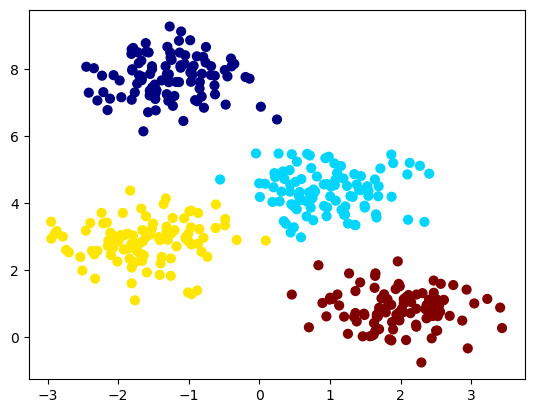

In [106]:
# Plot the data with k-means labels

kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');

- From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assignment of points between them.
- the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
- the *k*-means model places a circle (or, in higher dimensions, a hypersphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
- This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
- An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
- So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled, as you can see in the following figure:

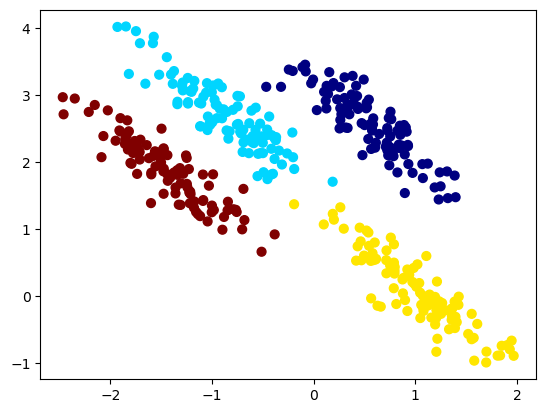

In [107]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels, s=40, cmap='jet');


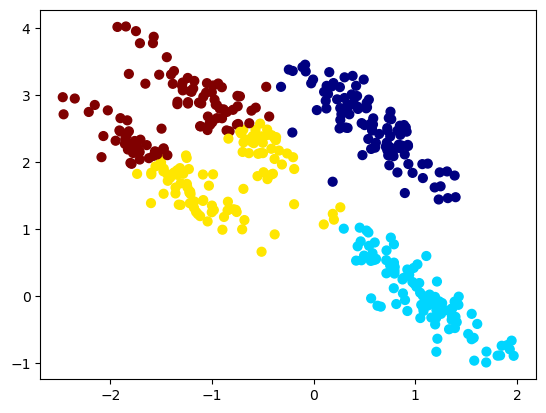

In [108]:
kmeans = KMeans(n_clusters=4, random_state=0)
labels_stretched = kmeans.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_stretched, s=40, cmap='jet');

- Two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of mechanism to evaluate the number of clusters. 
- We can solve these models by using a model with a probability funciton.  

### Gaussian Mixture Models

- A Gaussian mixture model (GMM) attempts to find a mixture of multidimensional Gaussian probability distributions that best model any input dataset.
- In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means (see the following figure):

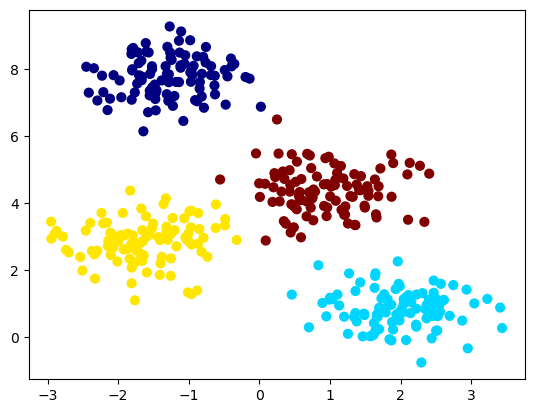

In [109]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');

- But because a GMM contains a probability model under the hood, it is also possible to find **probabilistic cluster assignments** using the `predict_proba` method.
- This returns a matrix of size `[n_samples, n_clusters]` which measures the probability that any point belongs to the given cluster:

In [110]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.463 0.    0.    0.537]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]]


We could use this to incorporate an expression of confidence in the clustering.  

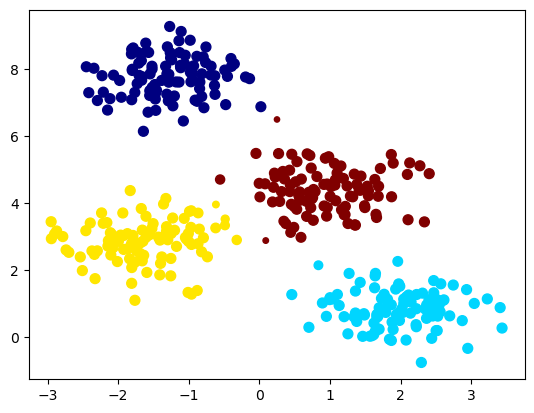

In [111]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet', s=size);

### Gaussian mixtures model is algorithmically very similar to *k*-means: it uses an 

- Expectation–<aximization approach, which qualitatively does the following:

-  Choose starting guesses for the location and shape.

- Repeat until converged:

   1. *E-step*: For each point, find weights encoding the probability of membership in each cluster.
   2. *M-step*: For each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights.

- The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian ellipsoid model.
- Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.  

In [112]:
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()

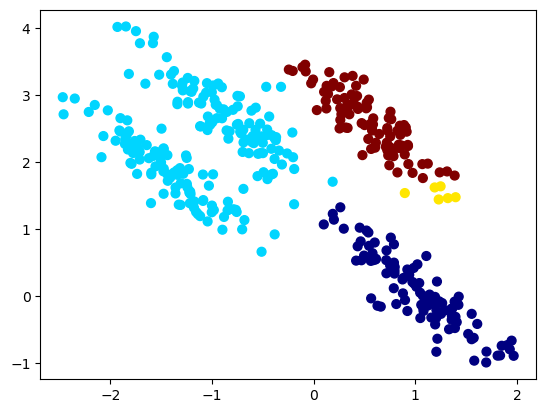

In [113]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
labels_gmm = gmm.fit(X_stretched).predict(X_stretched)
plt.scatter(X_stretched[:, 0], X_stretched[:, 1], c=labels_gmm, s=40, cmap='jet');
#plot_gmm(gmm,X_stretched)

This makes clear that GMMs address the two main practical issues with *k*-means encountered before.

#### Choosing the Covariance Type
- The `covariance_type` hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
- The default is `covariance_type="diag"`, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
- A slightly simpler and faster model is `covariance_type="spherical"`, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
- The model with the most freedom is to use `covariance_type="full"`, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

## Gaussian Mixture Models as Density Estimation

- Though the GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

- Each cluster is modeled as a multivariate normal distribution 

 $$ f(\boldsymbol{x}) = \frac{1}{(2\pi)^{p/2}\det(\boldsymbol{\Sigma})^{\frac{1}{2}}}e^{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\boldsymbol{\Sigma}^{-1}(\boldsymbol{x}-\boldsymbol{\mu})}$$

- The entire data distribution is modeled as a mixture of multivariate normals.  
- A GMM is convenient as a flexible means of modeling an arbitrary multidimensional distribution of data.


AIC and BIC 

Akaike Information Criterion:  With k parameters, and likelihood L 

$$ AIC = -2 ln(L) + 2k $$

Bayesian Information Criterion: With k parameters, likelihood L, and n observations 

$$ BIC = -2 ln(L) + k ln(n) $$
 



- The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that 120 distributions is the best choice of the values we tested
- Notice the important point: this choice of number of components measures how well a GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
- Important to confirm that the fit has converged. 